In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from dataset_build.clf_dtSet_hugo import build_purity_classification_dataset

In [67]:
N_SHOTS = 1000

df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
)

print(f"Dataset shape: {df_purity.shape}")
print(f"Labels distribution:\n{y.value_counts()}")
print(f"\nDataset columns:\n{df_purity.columns.tolist()}")
print(f"\X columns (à revoir):\n{X.columns.tolist()}")

df_purity.head()

Dataset shape: (5000, 14)
Labels distribution:
label_purity
1    2500
0    2500
Name: count, dtype: int64

Dataset columns:
['X_mean', 'Y_mean', 'Z_mean', 'X_real', 'Y_real', 'Z_real', 'theta_ideal', 'phi_ideal', 'X_ideal', 'Y_ideal', 'Z_ideal', 'bloch_radius_real', 'is_pure', 'label_purity']
\X columns (à revoir):
['X_mean', 'Y_mean', 'Z_mean', 'bloch_radius_real']


,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity
0,0.992,0.018,-0.174,0.994098,0.027009,-0.105071,1.676062,0.027163,0.994098,0.027009,-0.105071,1.000000,True,1
1,-0.334,0.350,0.866,-0.338218,0.355175,0.871470,0.512605,2.331744,-0.338218,0.355175,0.871470,1.000000,True,1
2,-0.102,0.288,0.942,-0.148654,0.279679,0.948516,0.322281,2.059338,-0.148654,0.279679,0.948516,1.000000,True,1
3,-0.284,0.420,-0.032,-0.326992,0.457914,-0.056871,1.737862,2.168606,-0.554997,0.815062,-0.166289,0.565547,False,0
4,0.902,-0.438,-0.108,0.912158,-0.391662,-0.120700,1.691792,5.877611,0.912158,-0.391662,-0.120700,1.000000,True,1


In [68]:
def compute_bloch_fidelity_kernel(R_A, R_B=None):
    """
    Calcule la matrice de noyau (Kernel Matrix) basée sur la fidélité quantique
    entre des vecteurs de Bloch, sans boucles Python lentes.
    
    Arguments:
        R_A : array (N, 3) - Vecteurs de Bloch du premier ensemble (ex: Train)
        R_B : array (M, 3) - Vecteurs de Bloch du second ensemble (ex: Test). 
              Si None, calcule la matrice symétrique R_A vs R_A.
              
    Retourne:
        K : array (N, M) - Matrice de fidélité
    """
    # Si R_B n'est pas fourni, on calcule la matrice carrée symétrique (Train vs Train)
    if R_B is None:
        R_B = R_A

    # 1. Calcul du produit scalaire pour toutes les paires (r . s)
    # C'est une multiplication matricielle : (N,3) @ (3,M) -> (N,M)
    dot_product_matrix = np.dot(R_A, R_B.T)
    
    # 2. Calcul des normes au carré (||r||^2 et ||s||^2)
    # axis=1 signifie qu'on somme x^2 + y^2 + z^2 pour chaque ligne
    r_sq_A = np.sum(R_A**2, axis=1) # Shape (N,)
    r_sq_B = np.sum(R_B**2, axis=1) # Shape (M,)
    
    # 3. Calcul du terme de déterminant : sqrt((1 - r^2)(1 - s^2))
    # Note : np.clip est vital ici car des données bruitées peuvent avoir r^2 > 1,
    # ce qui causerait des NaNs dans la racine carrée. On limite à 0 minimum.
    factor_A = np.sqrt(np.clip(1 - r_sq_A, 0, None))
    factor_B = np.sqrt(np.clip(1 - r_sq_B, 0, None))
    
    # On fait un "outer product" pour obtenir la matrice (N, M) de ces facteurs
    det_term_matrix = np.outer(factor_A, factor_B)
    
    # 4. Formule finale de la fidélité vectorisée
    # F = 0.5 * (1 + (r . s) + sqrt_term)
    K = 0.5 * (1 + dot_product_matrix + det_term_matrix)
    
    return K

In [69]:
# 1. Extraction des vecteurs de Bloch (X_mean, Y_mean, Z_mean)
# On suppose que ton dataframe s'appelle 'df'
cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
bloch_vectors = df_purity[cols_bloch].values  # Convertit en numpy array (N_samples, 3)
labels = df_purity['label_purity'].values     # Si tu as besoin des labels pour le SVM

# 2. Split Train / Test
# On splitte les vecteurs directement
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    bloch_vectors, labels, test_size=0.2, random_state=42
)

In [70]:
# 3. Calcul des Kernels (Instantanné grâce à la vectorisation)

# Matrice Train (Symétrique, taille N_train x N_train)
print("Calcul du Kernel Train...")
K_train = compute_bloch_fidelity_kernel(X_train_vec)

# Matrice Test (Rectangulaire, taille N_test x N_train)
# C'est ce dont le SVM a besoin pour prédire : la similarité du Test par rapport au Train
print("Calcul du Kernel Test...")
K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)

print(f"Shape K_train: {K_train.shape}")
print(f"Shape K_test: {K_test.shape}")

svc = SVC(kernel="precomputed", C=1.0)
svc.fit(K_train, y_train)

y_pred  = svc.predict(K_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Calcul du Kernel Train...


Calcul du Kernel Test...
Shape K_train: (4000, 4000)
Shape K_test: (1000, 4000)
Test accuracy: 0.9590

Classification report :
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       502
           1       0.93      0.99      0.96       498

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Matrice de confusion :
[[464  38]
 [  3 495]]


Training SVC models

In [71]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(1,10):
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=i*0.1  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values  # Convertit en numpy array (N_samples, 3)
    labels = df['label_purity'].values     # Si tu as besoin des labels pour le SVM

    # 2. Split Train / Test
    # On splitte les vecteurs directement
    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

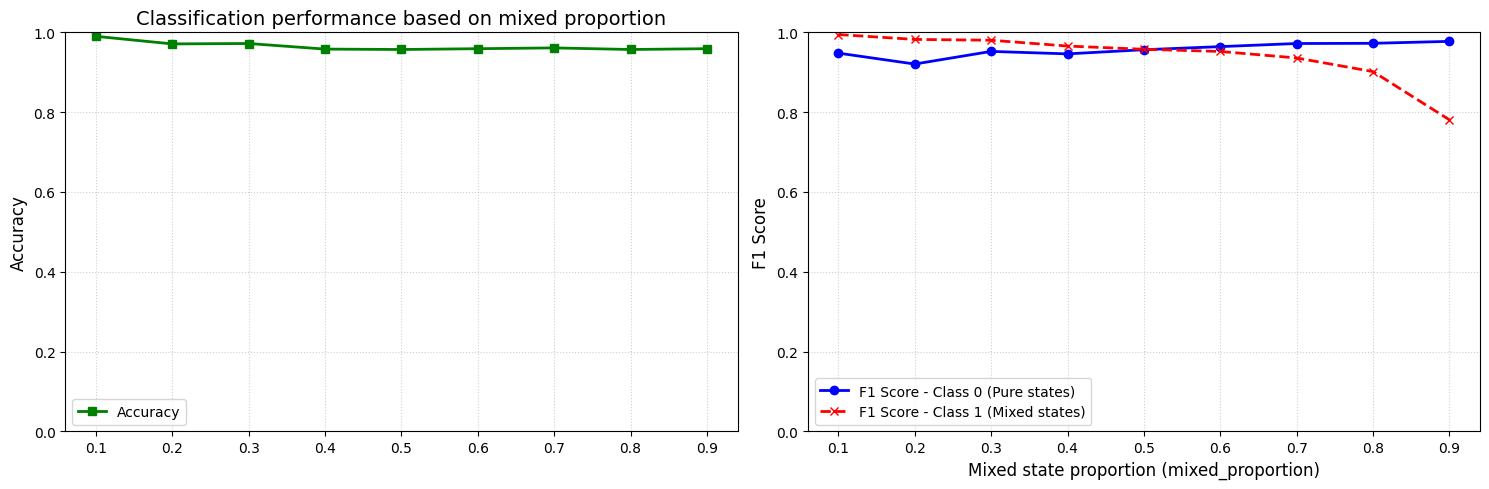

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 
# 'sharex=True' assure que les deux graphiques partagent le même axe des X, ce qui est idéal ici.

# --- SOUS-GRAPHIQUE 1 : Accuracy ---
ax1.plot(proportion, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance based on mixed proportion", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower left')
ax1.set_ylim(0, 1.0) # Définir la limite Y pour la lisibilité

# --- SOUS-GRAPHIQUE 2 : F1 Scores ---

# F1 Score pour la Classe 0 (États Purs)
ax2.plot(proportion, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')

# F1 Score pour la Classe 1 (États Mixtes)
ax2.plot(proportion, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Mixed state proportion (mixed_proportion)", fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower left')
ax2.set_ylim(0, 1.0) # Définir la limite Y pour la lisibilité

# Ajustement pour éviter la superposition des titres/étiquettes
plt.tight_layout()

# Afficher/Sauvegarder le graphique
plt.show()

In [73]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_states = [100, 200, 500, 1000, 2000, 5000]

for nstate in n_states:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=nstate,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values  # Convertit en numpy array (N_samples, 3)
    labels = df['label_purity'].values     # Si tu as besoin des labels pour le SVM

    # 2. Split Train / Test
    # On splitte les vecteurs directement
    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

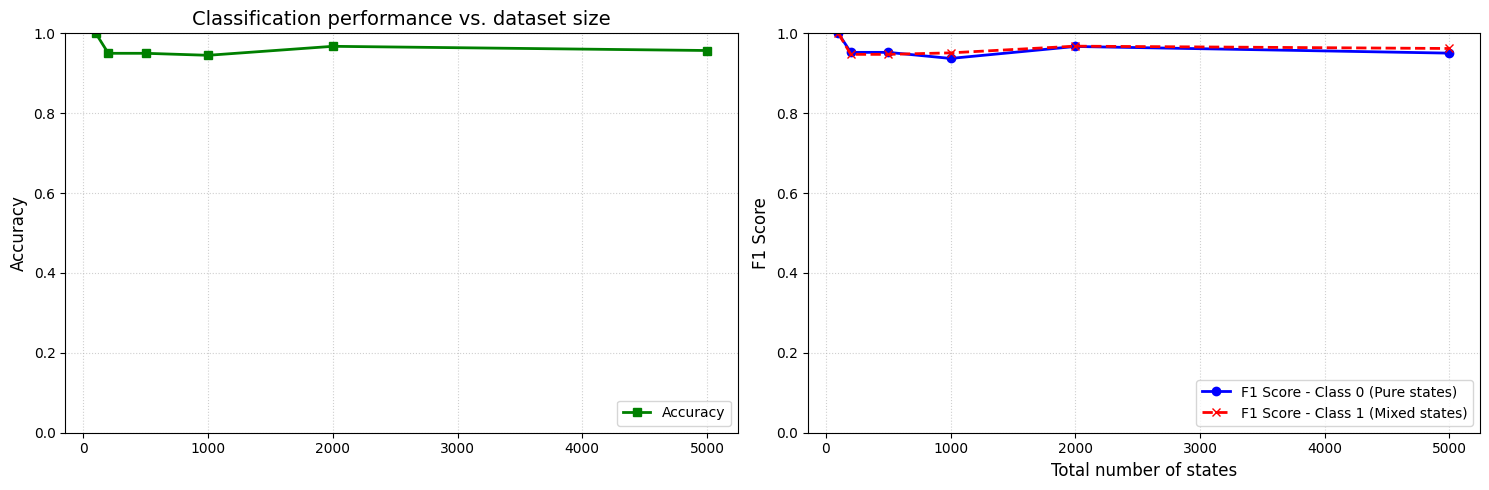

In [74]:



# Création de la figure et des deux sous-graphiques (2 lignes, 1 colonne)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

# --- SOUS-GRAPHIQUE 1 : Accuracy ---
ax1.plot(n_states, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance vs. dataset size", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower right')
# Optionnel : définir une limite Y pertinente
ax1.set_ylim(0, 1.0) 

# --- SOUS-GRAPHIQUE 2 : F1 Scores ---

# F1 Score pour la Classe 0 (États Purs)
ax2.plot(n_states, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')

# F1 Score pour la Classe 1 (États Mixtes)
ax2.plot(n_states, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
# L'axe X est maintenant étiqueté avec la variable indépendante
ax2.set_xlabel("Total number of states", fontsize=12) 
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
# Optionnel : définir une limite Y pertinente
ax2.set_ylim(0, 1.0) 

# Ajustement pour éviter la superposition
plt.tight_layout() 

# Afficher/Sauvegarder le graphique
plt.show()

In [75]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_shots = [10, 50, 100, 500, 1000, 5000]

for nshot in n_shots:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=nshot,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values  # Convertit en numpy array (N_samples, 3)
    labels = df['label_purity'].values     # Si tu as besoin des labels pour le SVM

    # 2. Split Train / Test
    # On splitte les vecteurs directement
    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

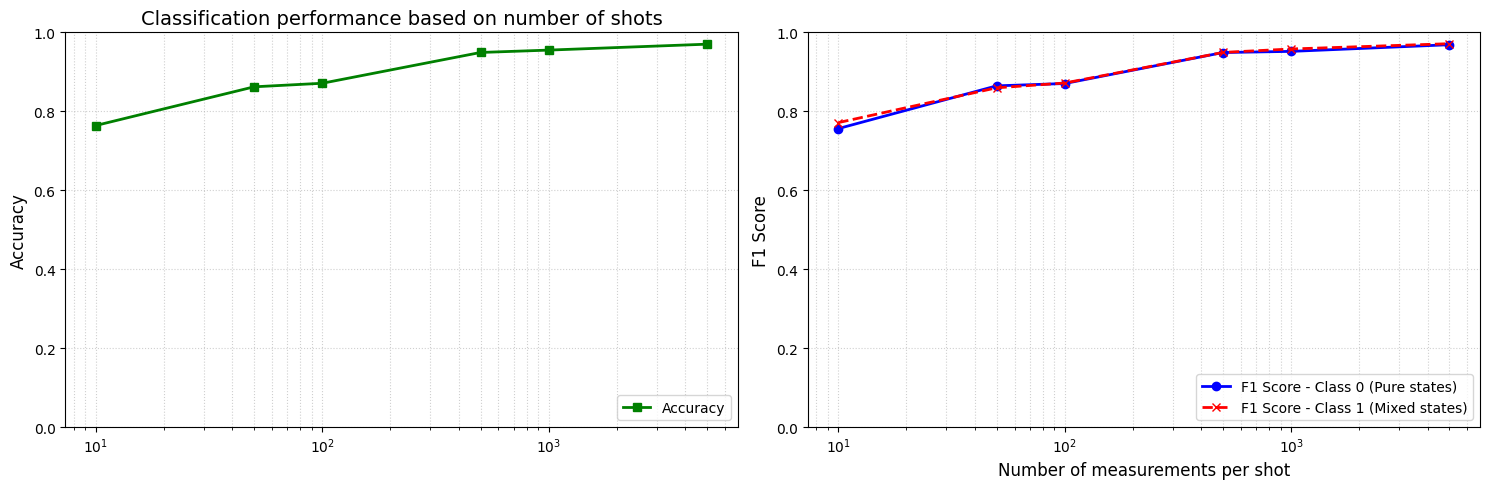

In [76]:


# Création de la figure et des deux sous-graphiques (2 lignes, 1 colonne)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

# --- SOUS-GRAPHIQUE 1 : Accuracy vs. n_shots ---
# Utilisation de plt.semilogx pour une meilleure visualisation
ax1.semilogx(n_shots, accs, 
             marker='s', linestyle='-', color='green', linewidth=2, 
             label='Accuracy')

ax1.set_title("Classification performance based on number of shots", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, which="both", linestyle=':', alpha=0.6) # Affichage des grilles principales et secondaires
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0) 


# --- SOUS-GRAPHIQUE 2 : F1 Scores vs. n_shots ---
# Utilisation de plt.semilogx pour une meilleure visualisation
ax2.semilogx(n_shots, f1_score_0, 
             marker='o', linestyle='-', color='blue', linewidth=2, 
             label='F1 Score - Class 0 (Pure states)')

ax2.semilogx(n_shots, f1_score_1, 
             marker='x', linestyle='--', color='red', linewidth=2, 
             label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
# Étiquette de l'axe X pour les deux graphiques
ax2.set_xlabel("Number of measurements per shot", fontsize=12) 
ax2.grid(True, which="both", linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.0) 

# Ajustement final
plt.tight_layout() 

# Afficher/Sauvegarder le graphique
plt.show()